# Sunspots - Analysis

In [158]:
# import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.api as sm

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss, acf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



# from dateutil.parser import parse
# from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")

## Importing data

In [14]:
df = pd.read_csv('Sunspots.csv', parse_dates=['Date'], index_col='Date')['Monthly Mean Total Sunspot Number']
df.head()

Date
1749-01-31     96.7
1749-02-28    104.3
1749-03-31    116.7
1749-04-30     92.8
1749-05-31    141.7
Name: Monthly Mean Total Sunspot Number, dtype: float64

## Visualizing Sunspots Time Series Data

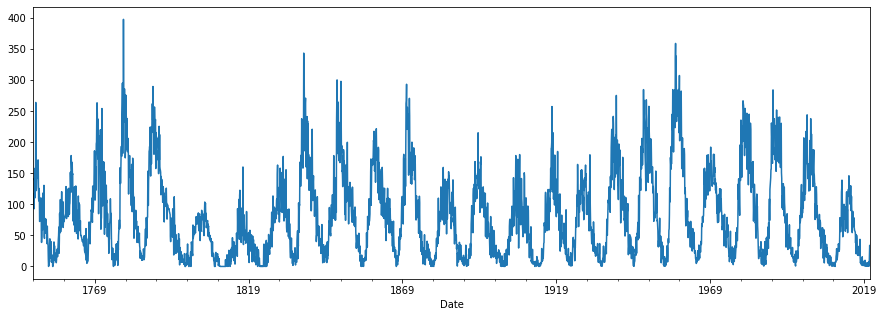

In [15]:
df.plot(figsize=(15,5))
plt.show()

## Testing for Stationarity

There are multiple implementations of Unit Root tests like:

Augmented Dickey Fuller test (ADH Test)
Kwiatkowski-Phillips-Schmidt-Shin – KPSS test (trend stationary)
Philips Perron test (PP Test)
The most commonly used is the ADF test, where the null hypothesis is the time series possesses a unit root and is non-stationary. So, id the P-Value in ADH test is less than the significance level (0.05), you reject the null hypothesis.

In [16]:
# ADF Test
result = adfuller(df, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(df, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -10.497051662546154
p-value: 1.1085524921955702e-18
Critial Values:
   1%, -3.4323724026124003
Critial Values:
   5%, -2.8624335760905684
Critial Values:
   10%, -2.5672456699774324

KPSS Statistic: 0.103805
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


### Another possibility

In [17]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(120).mean() 
    rolstd = timeseries.rolling(120).std()
    
    #Plot rolling statistics:
    plt.figure(figsize=(20,5))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

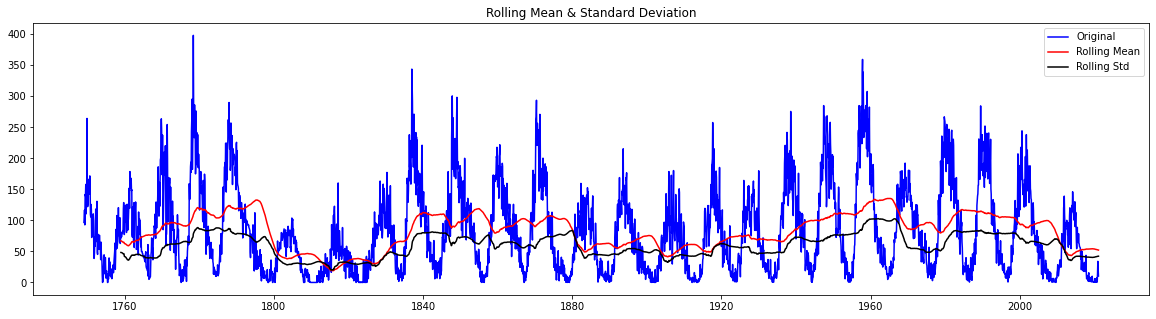

Results of Dickey-Fuller Test:
Test Statistic                -1.049705e+01
p-value                        1.108552e-18
#Lags Used                     2.800000e+01
Number of Observations Used    3.236000e+03
Critical Value (1%)           -3.432372e+00
Critical Value (5%)           -2.862434e+00
Critical Value (10%)          -2.567246e+00
dtype: float64


In [18]:
test_stationarity(df)

####  <span style="color:red">It's  best to leave a graph with the rolling mean and the standard deviation?</span>
    
note: to calculate the rolling mean and the standard deviation, I've used the time period (k) as 120 months since the data appears to have 10 year cycles. 

## Time Series Decomposition

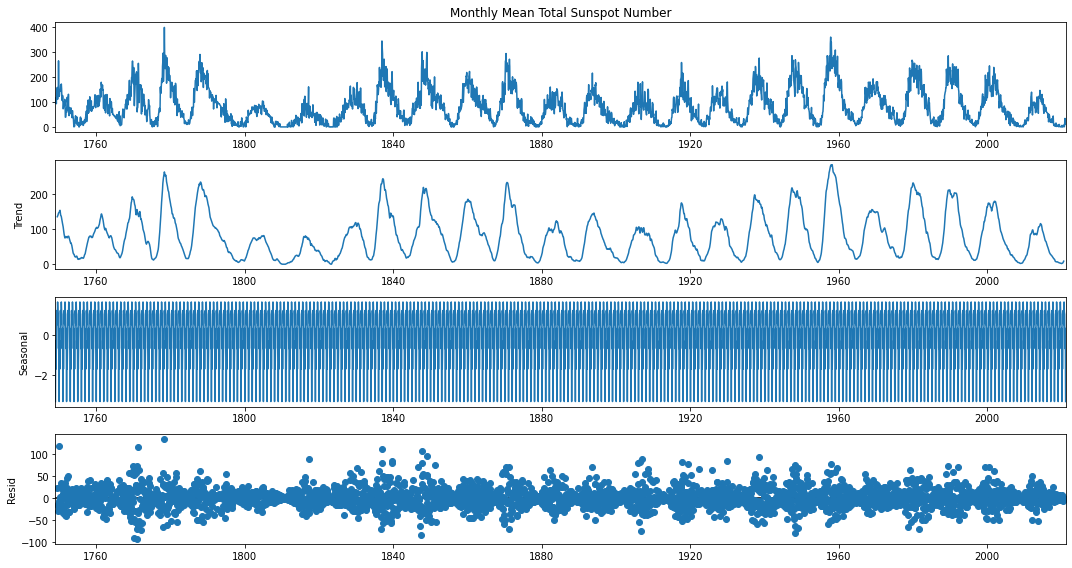

In [27]:
decomposition = sm.tsa.seasonal_decompose(df, model='additive')

matplotlib.rcParams['figure.figsize'] = 15, 8
decomposition.plot()
plt.show()

# Forecasts

In [221]:
# Split time series data into training and test set

train_data = int(len(df)*0.8)

train = df[0: train_data] # train with the first 80% of the data
test = df[train_data:] # test with the last 20% of the data

In [33]:
# function evaluate forecast accuracy 

def calculate_error(test_data, model_data):
    
    rmse = np.sqrt(np.mean((test_data - model_data)**2)).round(2)
    mae = np.mean(np.abs(test_data - model_data)).round(2) 
    mape = np.mean((np.abs(test_data - model_data) / test_data)*100).round(2)

    return print(f"RMSE: {rmse} \nMAE: {mae} \nMAPE: {mape}")

# Is it interesting to add other types of error measurement?

In [34]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(forecast-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

In [231]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

## 1. Mean Model

#### Add notes

In [35]:
y_hat_mean = test.copy()
y_hat_mean = y_hat_mean.apply(lambda x: df.mean())

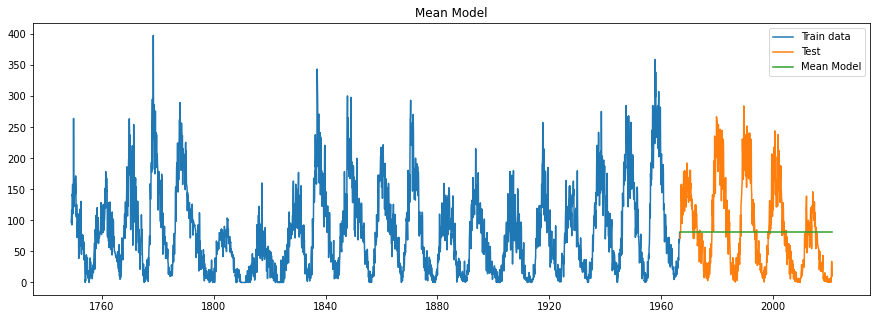

In [36]:
# Plotting the Mean Model Graph

plt.figure(figsize=(15,5))
plt.title('Mean Model')
plt.plot(train, label='Train data')
plt.plot(test, label='Test')
plt.plot(y_hat_mean, label='Mean Model')
plt.legend(loc='best')
plt.show()

#### Calculating RMSE and MAPE

In [37]:
calculate_error(test, y_hat_mean)

RMSE: 69.44 
MAE: 58.36 
MAPE: inf


## 2. Exponencial smoothing

In [38]:
fit_1 = SimpleExpSmoothing(train).fit(smoothing_level=0.2)
fit_2 = SimpleExpSmoothing(train).fit(smoothing_level=0.6)
fit_3 = SimpleExpSmoothing(train).fit()

In [39]:
fcast_1 = fit_1.forecast(653)
fcast_2 = fit_2.forecast(653)
fcast_3 = fit_3.forecast(653)

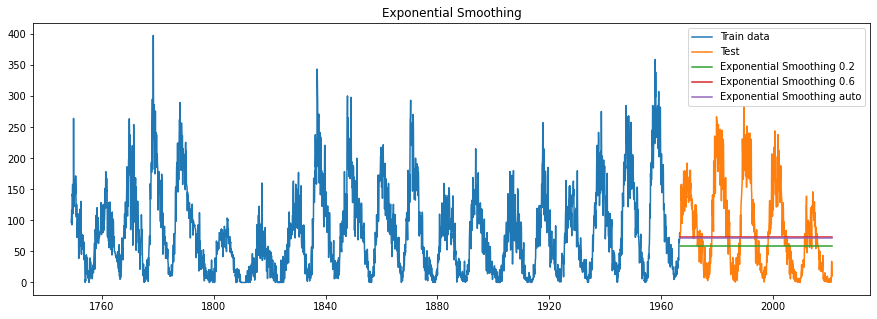

In [40]:
# Plotting the Exponential Smoothing Graph
plt.rcParams.update({'figure.figsize':(15,5)})

plt.title('Exponential Smoothing')
plt.plot(train, label='Train data')
plt.plot(test, label='Test')
plt.plot(fcast_1, label='Exponential Smoothing 0.2')
plt.plot(fcast_2, label='Exponential Smoothing 0.6')
plt.plot(fcast_3, label='Exponential Smoothing auto')
plt.legend(loc='best')
plt.show()

In [41]:
calculate_error(test, fcast_1)

RMSE: 75.02 
MAE: 58.98 
MAPE: inf


In [42]:
calculate_error(test, fcast_2)

RMSE: 70.58 
MAE: 57.97 
MAPE: inf


In [43]:
calculate_error(test, fcast_3)

RMSE: 70.74 
MAE: 57.97 
MAPE: inf


# ARIMA

### Time series forecasting with ARIMA

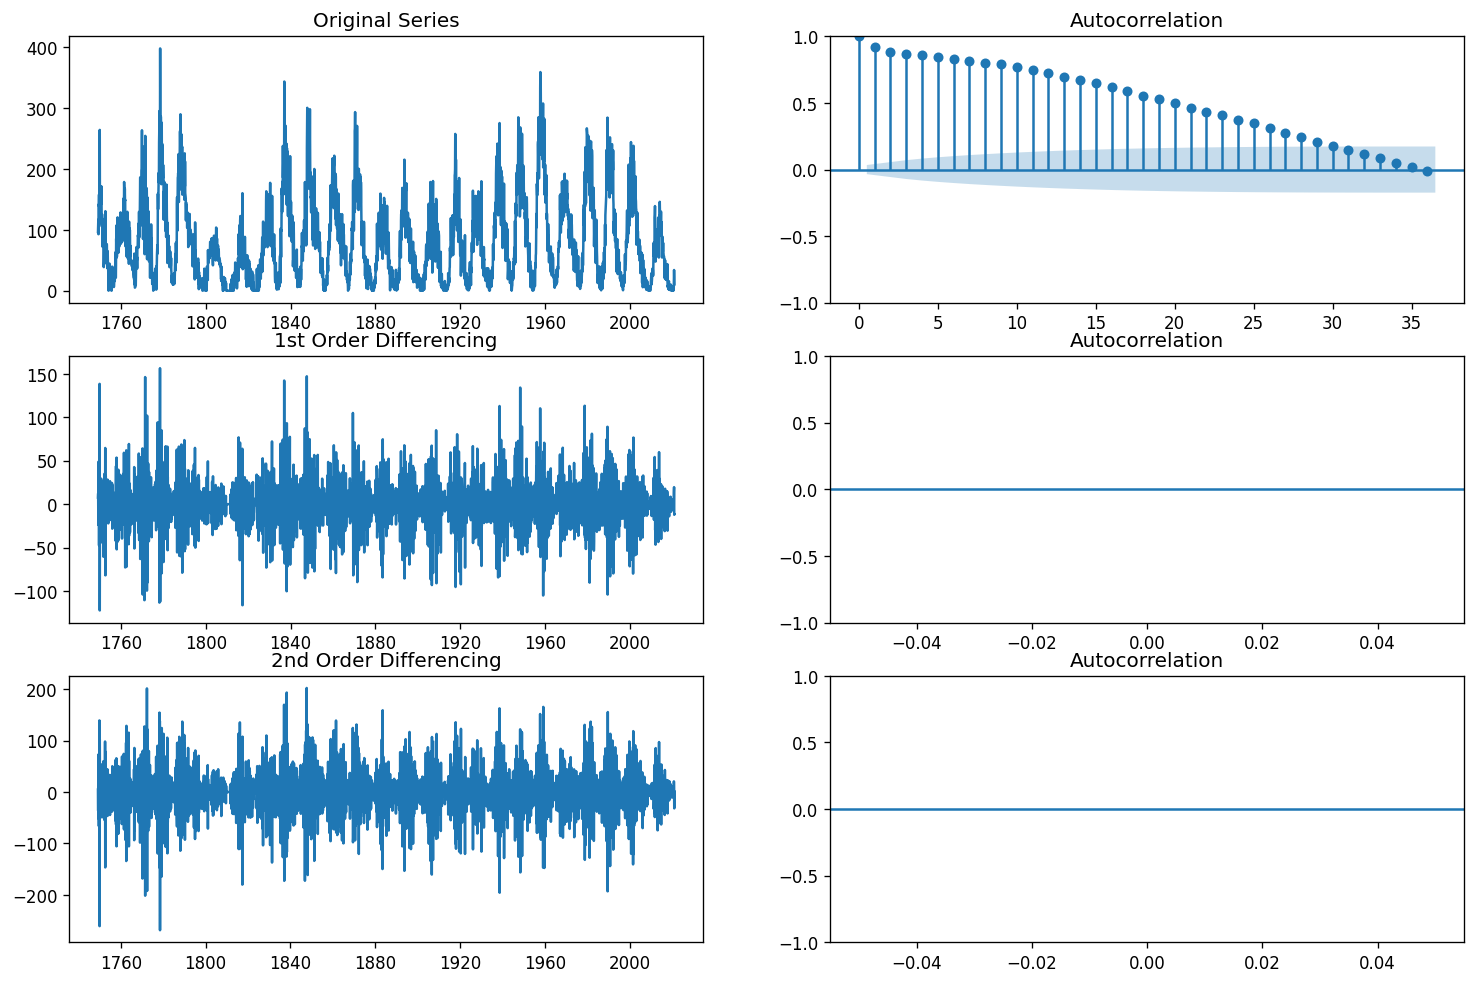

In [238]:
plt.rcParams.update({'figure.figsize':(15,10)})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=False)
axes[0, 0].plot(df)
axes[0, 0].set_title('Original Series')
plot_acf(df, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.diff()) 
axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.diff(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.diff().diff())
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.diff(), ax=axes[2, 1]);

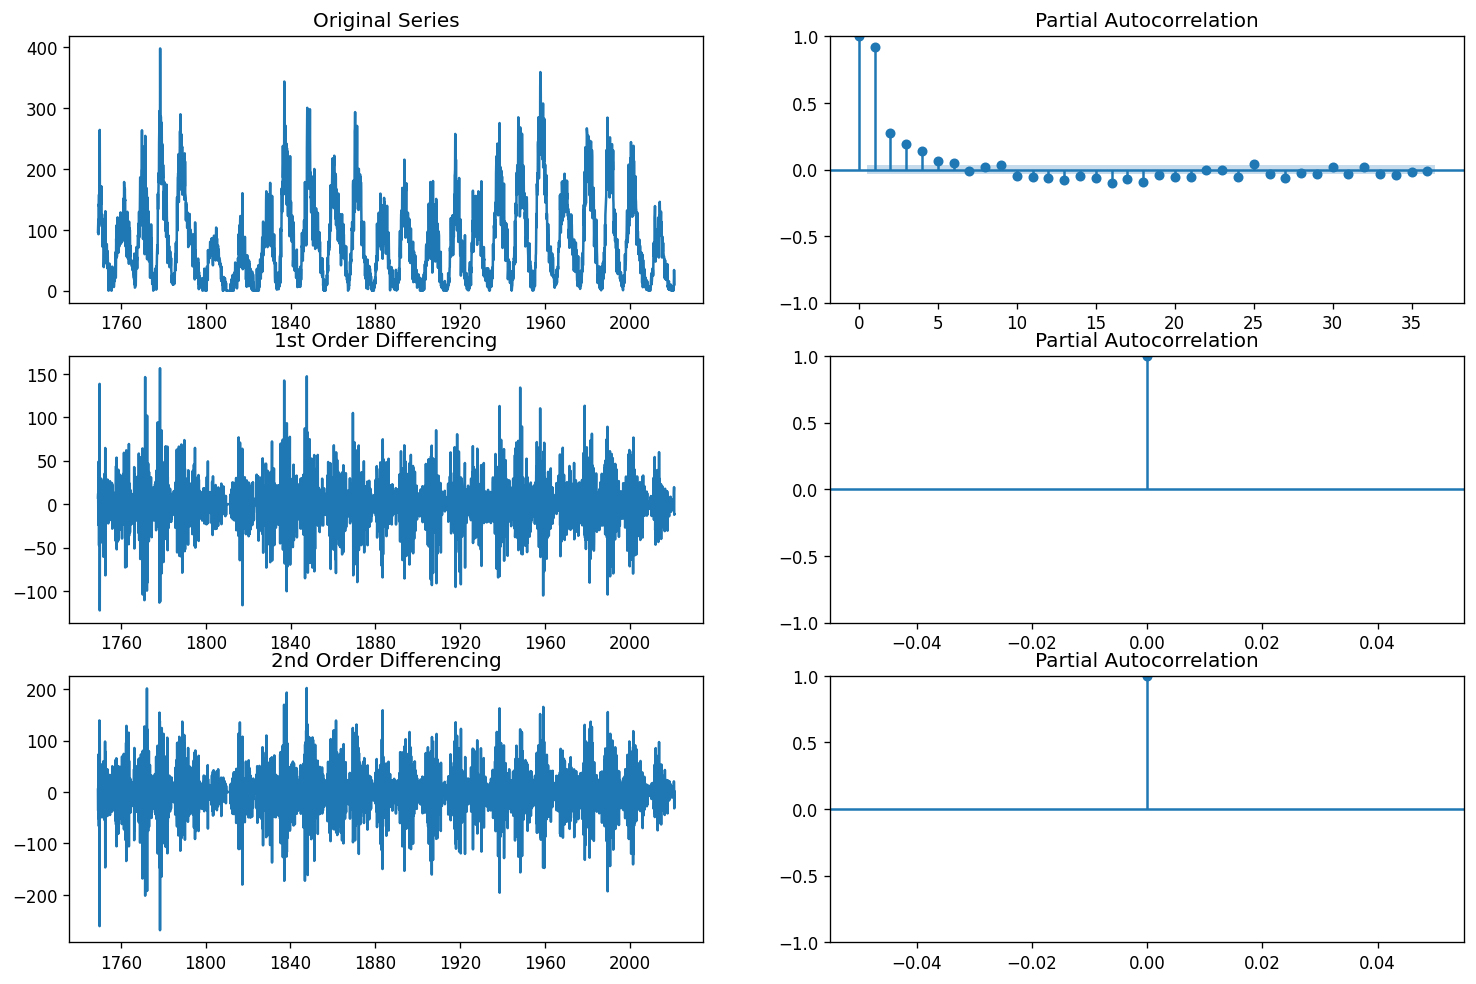

In [239]:
plt.rcParams.update({'figure.figsize':(15,10)})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=False)
axes[0, 0].plot(df)
axes[0, 0].set_title('Original Series')
plot_pacf(df, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.diff()) 
axes[1, 0].set_title('1st Order Differencing')
plot_pacf(df.diff(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.diff().diff())
axes[2, 0].set_title('2nd Order Differencing')
plot_pacf(df.diff(), ax=axes[2, 1]);

#### d = 0   
Because, you need differencing only if the series is non-stationary. Else, no differencing is needed, that is, d=0.

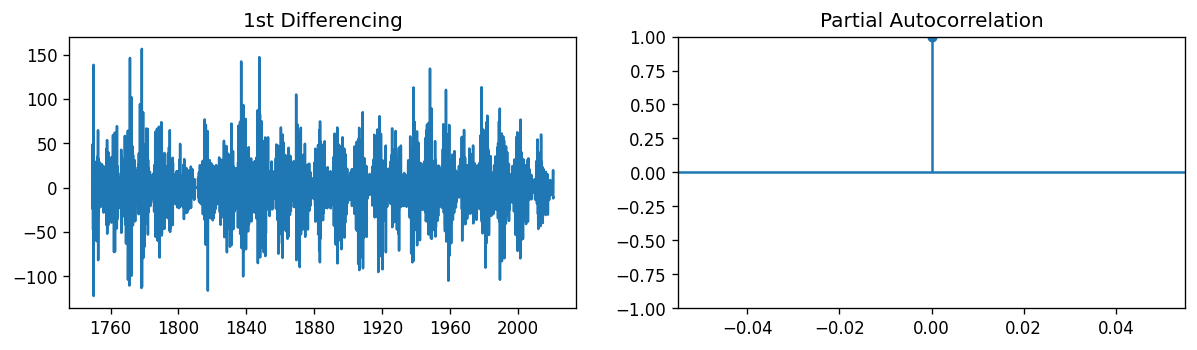

In [240]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(12,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(df.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.diff(), ax=axes[1])

plt.show()

## Another try to understand

https://www.projectpro.io/article/how-to-build-arima-model-in-python/544#:~:text=Model%20in%20Python%3F-,ARIMA%20Model%2D%20Complete%20Guide%20to%20Time%20Series%20Forecasting%20in%20Python,data%20to%20predict%20future%20values

## How to choose p, d and q for the ARIMA model:

### How to find the order of differencing (d):

you need differencing only if the series is non-stationary. Else, no differencing is needed, that is, d=0.

The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed stationary.

#### p = 0

### How to find the order of the AR term (p):

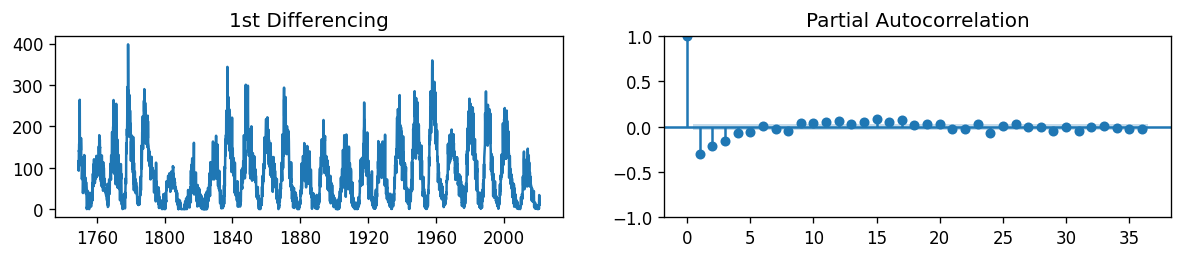

In [68]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(12,2), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(df); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.diff().dropna(), ax=axes[1])

plt.show()

#### Não entendi muito bem como definir o p. 

### How to find the order of the AR term (p):

Just like how we looked at the PACF plot for the number of AR terms, you can look at the ACF plot for the number of MA terms. An MA term is technically, the error of the lagged forecast.

The ACF tells how many MA terms are required to remove any autocorrelation in the stationarized series.

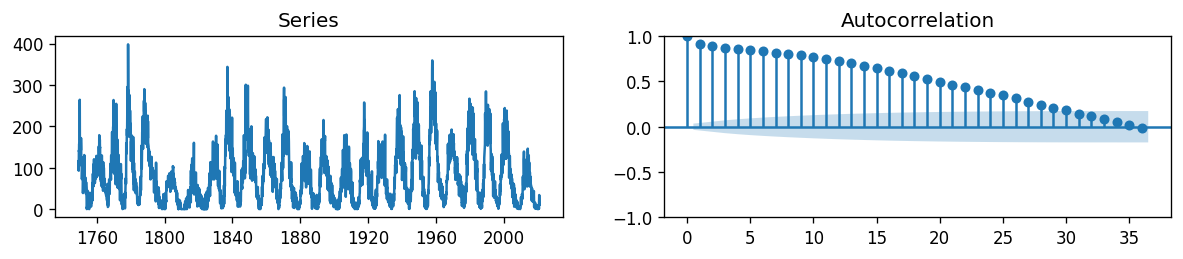

In [73]:
fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(df); axes[0].set_title('Series')
axes[1].set(ylim=(0,1.2))
plot_acf(df, ax=axes[1])

plt.show()

Couple of lags are well above the significance line. So, let’s tentatively fix q as 2. When in doubt, go with the simpler model that sufficiently explains the Y.


Não entendi muito bem

### How to build the ARIMA Model

In [138]:
# 2,1,0 ARIMA Model
model = ARIMA(df, order=(2,1,0))
model_fit = model.fit()
print(model_fit.summary())

                                       SARIMAX Results                                       
Dep. Variable:     Monthly Mean Total Sunspot Number   No. Observations:                 3265
Model:                                ARIMA(2, 1, 0)   Log Likelihood              -15211.750
Date:                               Tue, 05 Jul 2022   AIC                          30429.501
Time:                                       12:15:12   BIC                          30447.773
Sample:                                   01-31-1749   HQIC                         30436.045
                                        - 01-31-2021                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3668      0.013    -28.389      0.000      -0.392      -0.341
ar.L2      

In [128]:
# 2,2,0 ARIMA Model
model = ARIMA(df, order=(2,2,0))
model_fit = model.fit()
print(model_fit.summary())

                                       SARIMAX Results                                       
Dep. Variable:     Monthly Mean Total Sunspot Number   No. Observations:                 3265
Model:                                ARIMA(2, 2, 0)   Log Likelihood              -16017.016
Date:                               Tue, 05 Jul 2022   AIC                          32040.032
Time:                                       12:10:06   BIC                          32058.303
Sample:                                   01-31-1749   HQIC                         32046.576
                                        - 01-31-2021                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8223      0.011    -73.322      0.000      -0.844      -0.800
ar.L2      

In [159]:
# 0,3,2 ARIMA Model - Best Model
model = ARIMA(df, order=(0,3,2))
model_fit = model.fit()
print(model_fit.summary())

                                       SARIMAX Results                                       
Dep. Variable:     Monthly Mean Total Sunspot Number   No. Observations:                 3265
Model:                                ARIMA(0, 3, 2)   Log Likelihood              -15508.029
Date:                               Tue, 05 Jul 2022   AIC                          31022.058
Time:                                       14:31:06   BIC                          31040.329
Sample:                                   01-31-1749   HQIC                         31028.602
                                        - 01-31-2021                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.9755      0.003   -601.138      0.000      -1.982      -1.969
ma.L2      

In [244]:
aid_data = pd.DataFrame(columns=('pqd', 'aic'))

,pqd,aic


In [243]:
#### teste - trying to find the lowest AICa

def aic_find(timeseries):
    
    for p in range(0,3):
        for q in range(0,4):
            for d in range(0,3):
                model = ARIMA(df, order=(p,q,d))
                model_fit = model.fit()
                aic = model_fit.aic
            
                print(f"ARIMA({p}, {q}, {d}) AIC = {aic}");
            
            
            

ARIMA(0, 0, 0) AIC = 36811.4124837346
ARIMA(0, 0, 1) AIC = 34223.10064907566
ARIMA(0, 0, 2) AIC = 32960.38344891935
ARIMA(0, 1, 0) AIC = 30887.77939415055
ARIMA(0, 1, 1) AIC = 30380.700203125154
ARIMA(0, 1, 2) AIC = 30329.21884825292
ARIMA(0, 2, 0) AIC = 34004.647085742305
ARIMA(0, 2, 1) AIC = 30889.423639977707
ARIMA(0, 2, 2) AIC = 30383.777894264713
ARIMA(0, 3, 0) AIC = 37744.6214995353
ARIMA(0, 3, 1) AIC = 34005.55011083077
ARIMA(0, 3, 2) AIC = 31022.058226505542
ARIMA(1, 0, 0) AIC = 30766.404602844068
ARIMA(1, 0, 1) AIC = 30360.870706367907
ARIMA(1, 0, 2) AIC = 30316.78128528117
ARIMA(1, 1, 0) AIC = 30575.46437735494
ARIMA(1, 1, 1) AIC = 30333.40391063471
ARIMA(1, 1, 2) AIC = 30331.183798591414
ARIMA(1, 2, 0) AIC = 32679.337774190346
ARIMA(1, 2, 1) AIC = 30577.715289739892
ARIMA(1, 2, 2) AIC = 30336.745775970092
ARIMA(1, 3, 0) AIC = 35550.594533070456
ARIMA(1, 3, 1) AIC = 32681.312197540366
ARIMA(1, 3, 2) AIC = 30746.28283126843
ARIMA(2, 0, 0) AIC = 30515.00808074823
ARIMA(2, 0, 1)

### Final coeficients

fiquei na dúvida aqui também, fui chutando alguns valores e tentei achar os menores erros. Mas tem um ponto, qual metrica olhar?
- AIC?
- std_err?


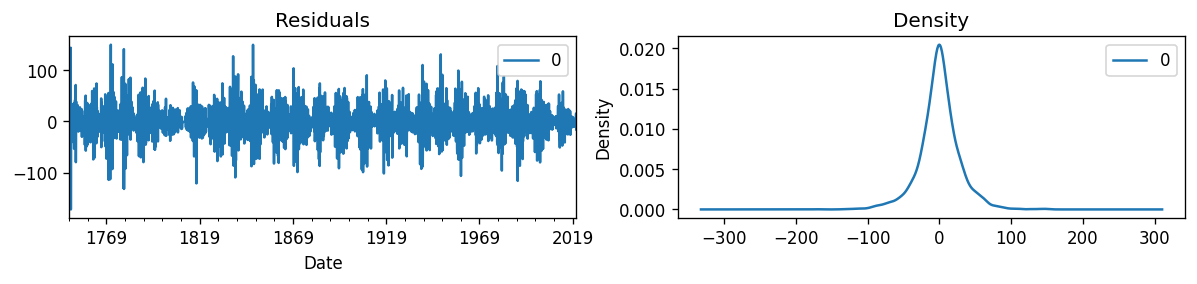

In [136]:
# Plot residual errors (0,3,2)
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

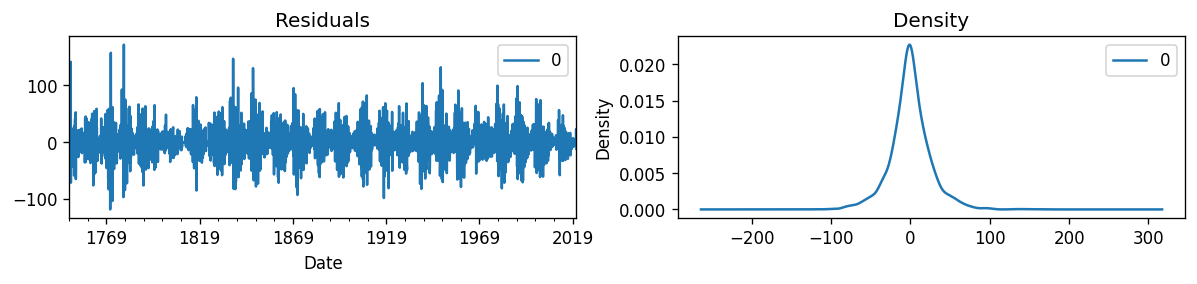

In [139]:
# Plot residual errors (2,1,0)
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [ ]:
# Plot residual errors (2,1,0) - lowest AIC
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

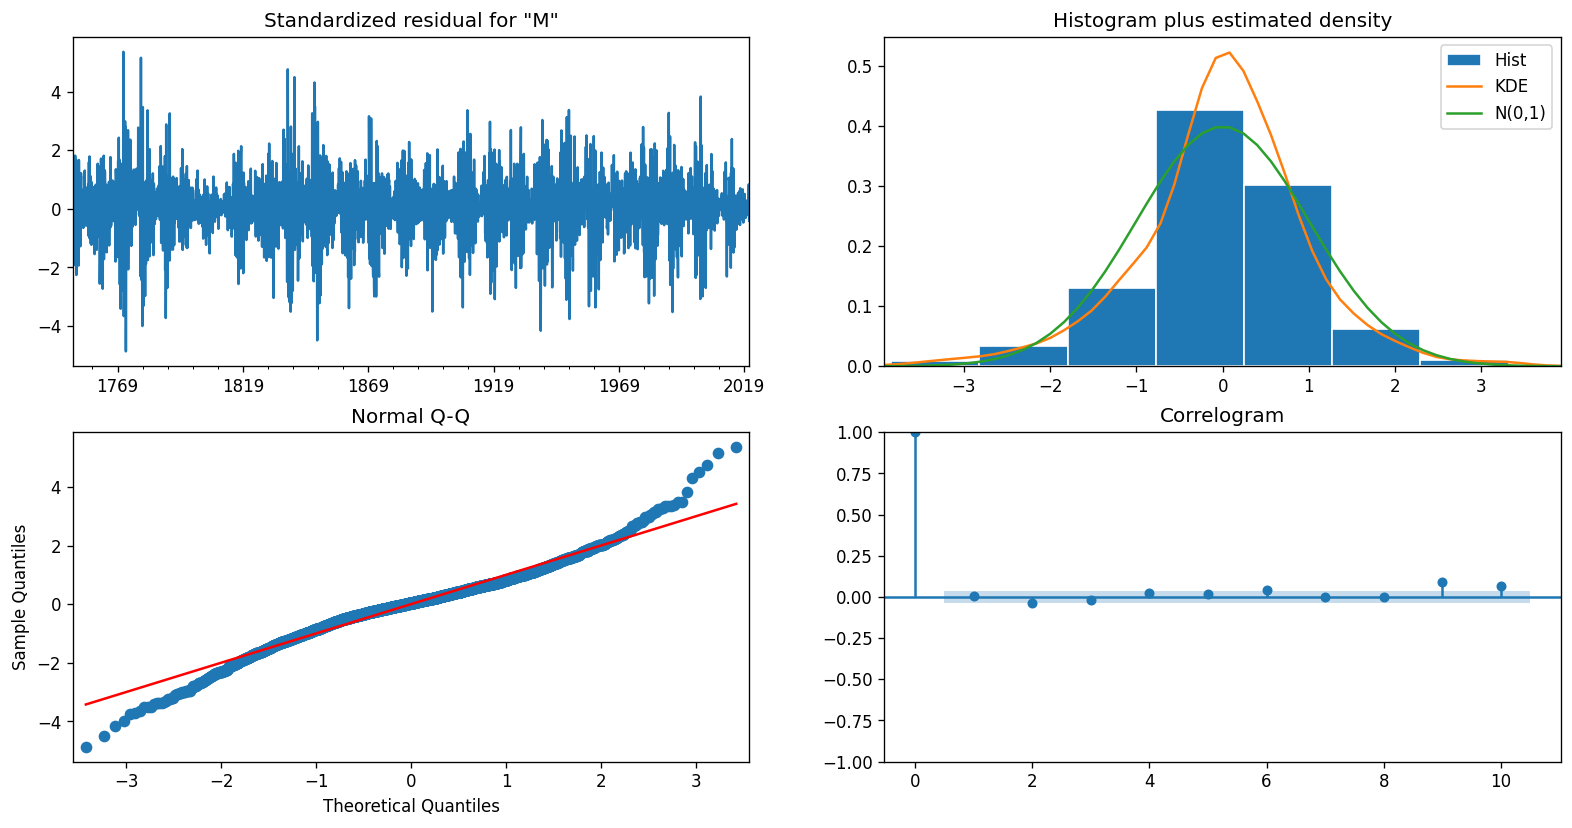

In [178]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

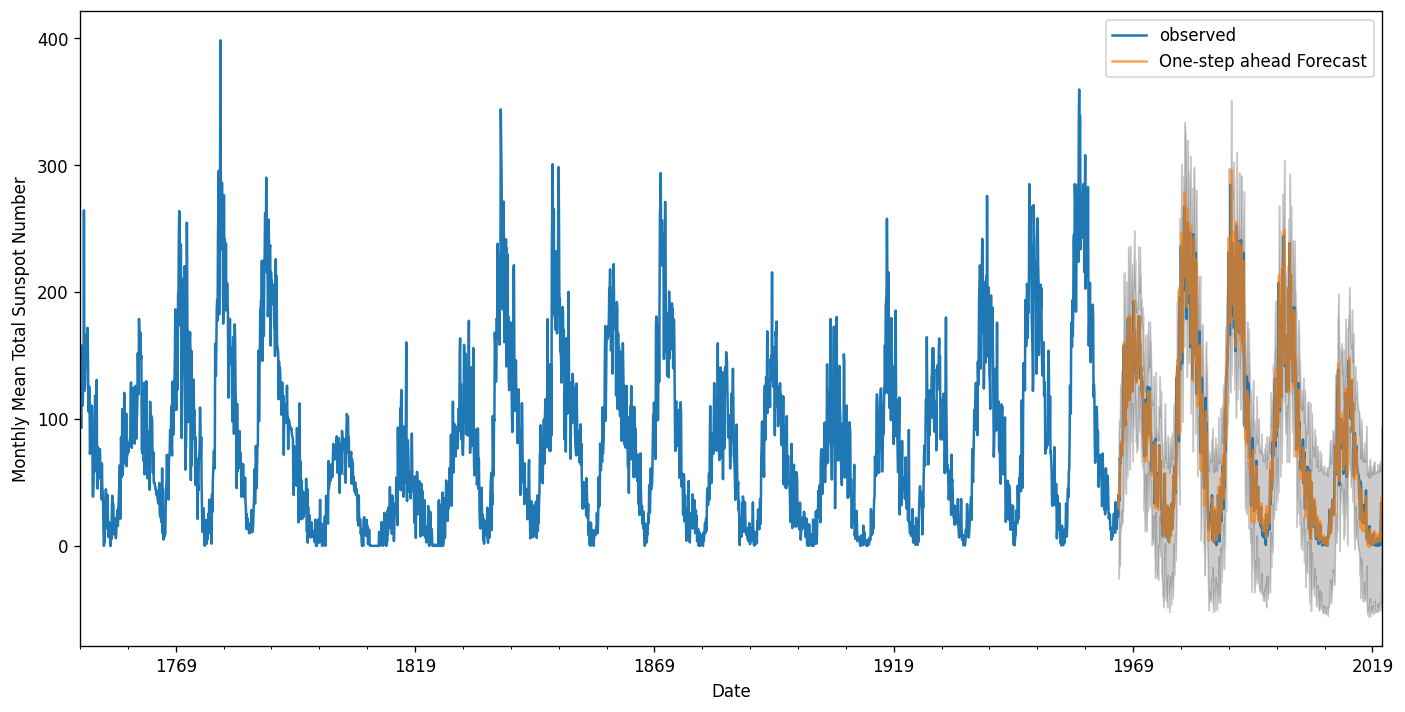

In [180]:
# Actual vs Fitted
pred = model_fit.get_prediction(start=pd.to_datetime('1966-01-31'), dynamic=False)
pred_ci = pred.conf_int()
ax = df.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Monthly Mean Total Sunspot Number')
plt.legend()
plt.show()

In [186]:
calculate_error(test, pred.predicted_mean)

RMSE: 25.63 
MAE: 18.62 
MAPE: inf


In [213]:
forecast_accuracy(test, pred.predicted_mean[8:])

{'mape': 0.611777879064667,
 'me': 0.08575591832233673,
 'mae': 18.617217732099096,
 'mpe': -0.07047478107337901,
 'rmse': 25.631784076033867,
 'acf1': nan,
 'corr': 0.9326504608536571,
 'minmax': 0.27135954762638603}

### Producing and visualizing forecasts

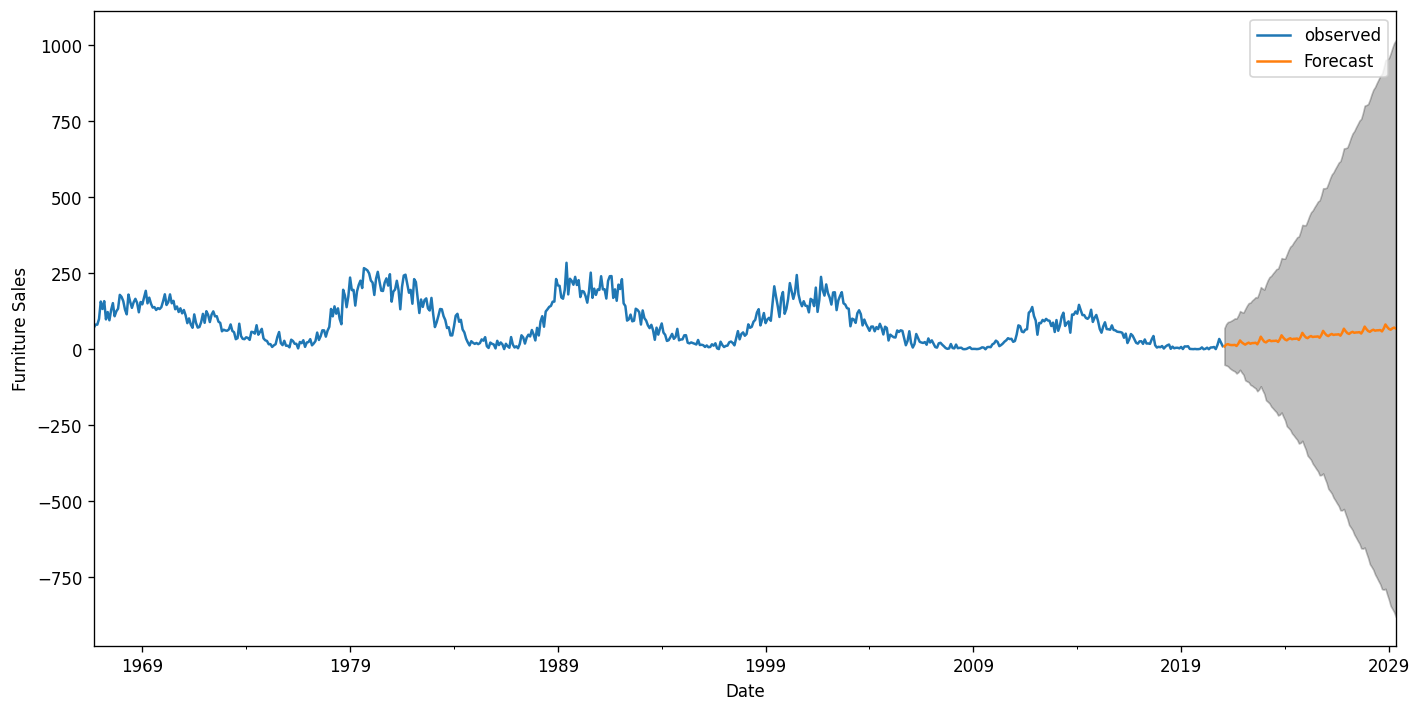

In [230]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = test.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

# Bibliography

* Hyndman, R. J., & Koehler, A. B. (2006). Another look at measures of forecast accuracy. International Journal of Forecasting, 22(4), 679–688. [DOI]
* Forecasting: principles and practice, 2013.
* https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/